In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import _autolag
from statsmodels.tsa.api import VAR
#from scipy.stats import pearsonr

DATA PREPARATION

In [159]:
data_df=pd.read_excel('Gas Data processed.xlsx',sheet_name="code")
df=data_df.loc[38:97,["year", "coal_gen", "gas_gen", "price_gas", "price_brent","open_interest_gas","ets","temperature"]] 
print(df)

#first ets value at line 38

              year  coal_gen  gas_gen   price_gas  price_brent  \
38  Quarter 3 2007   25.6247  36.5543   51.080432    95.042017   
39  Quarter 4 2007   42.2876  39.5451   62.164090   111.593341   
40  Quarter 1 2008   33.4249  47.6124   68.556213   118.698225   
41  Quarter 2 2008   26.2931  41.9255   85.133566   162.404181   
42  Quarter 3 2008   22.0066  43.2801   97.887486   112.709529   
43  Quarter 4 2008   36.3285  40.1696   67.121560    52.282110   
44  Quarter 1 2009   37.8068  37.2688   36.747126    56.586207   
45  Quarter 2 2009   19.1026  38.1096   29.601367    78.929385   
46  Quarter 3 2009   15.5716  42.0710   36.757370    78.310658   
47  Quarter 4 2009   25.3169  46.0059   38.058691    87.957111   
48  Quarter 1 2010   30.9666  47.3291   33.344557    92.817059   
49  Quarter 2 2010   18.5478  44.6790   50.544444    83.344444   
50  Quarter 3 2010   18.8051  40.1098   52.403101    91.151717   
51  Quarter 4 2010   33.8568  40.3353   67.036224   104.006586   
52  Quarte

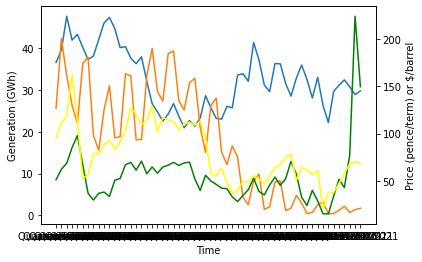

In [160]:
plt.plot(df.year, df.gas_gen)
plt.plot(df.year, df.coal_gen)
plt.xlabel("Time")
plt.ylabel("Generation (GWh)")
#plt.grid()
plt2=plt.twinx()
plt2.plot(df.year, df.price_gas, color="green")
plt2.plot(df.year, df.price_brent, color="yellow")
plt2.set_ylabel("Price (pence/term) or $/barrel", color="black")
#plt.ylabel
plt.show()

In [161]:
#Vector:
dcoal=df.coal_gen
dgas=df.gas_gen
dprice_gas=df.price_gas
dprice_brent=df.price_brent
dOI=df.open_interest_gas
dETS=df.ets
dtemp=df.temperature

DataSeries=[dcoal,dgas,dprice_gas, dprice_brent,dOI,dETS,dtemp]
#DataSeries=[dcoal,dgas,dprice_gas]

df_test = pd.concat(DataSeries,axis=1)

In [162]:
######### INITIAL DATA TESTS #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary

from statsmodels.tsa.stattools import adfuller, kpss
######## NORMALITY TEST V2 ########

def normality_test_matrix(data, variables, test):    
    """Check normality test to comply with general model assumptions.
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    test      : type of test to perform
    """

    col=['test statistic ','p-value ', 'lags used ']
    df = pd.DataFrame(np.zeros((len(variables), 3)), columns=col, index=variables)
    for r in df.index:
        if test == "Dickey-Fuller":
            dftestdickey = adfuller(data[r].values, autolag='AIC')
            for c in range(0,len(col)):
                df.loc[r, col[c]] = dftestdickey[c]           
        elif test == "KPSS":
            dftestkpss = kpss(data[r].values, regression='c', nlags="auto")
            for c in range(0,len(col)):
                df.loc[r, col[c]] = dftestkpss[c]

    print("Results for "+test+" test")
    df.columns = [var + test for var in col]

    #df.index = [var for var in variables]s
    return df


### styles ###

def highlight_cells_DF(series):
    highlight_true = 'background-color: green;'
    highlight_false = 'background-color: red;'
    default = ''
    return [highlight_true if e < 0.05 else highlight_false for e in series]  

def highlight_cells_KPSS(series):
    highlight_true = 'background-color: green;'
    highlight_false = 'background-color: red;'
    default = ''
    return [highlight_true if e > 0.05 else highlight_false for e in series]  


dfdifull = normality_test_matrix(df_test, variables = df_test.columns, test="Dickey-Fuller")
dfdifull.style.apply(highlight_cells_DF, subset=['p-value Dickey-Fuller'], axis=0)

Results for Dickey-Fuller test


,test statistic Dickey-Fuller,p-value Dickey-Fuller,lags used Dickey-Fuller
coal_gen,-0.192597,0.939398,11.000000
gas_gen,-2.007914,0.283114,2.000000
price_gas,-3.453892,0.009253,4.000000
price_brent,-2.228530,0.196054,0.000000
open_interest_gas,-1.716164,0.422804,6.000000
ets,2.869431,1.000000,6.000000
temperature,-1.122014,0.706214,11.000000


In [163]:
dfkpss = normality_test_matrix(df_test, variables = df_test.columns, test="KPSS")
dfkpss.style.apply(highlight_cells_KPSS, subset=['p-value KPSS'], axis=0)

Results for KPSS test


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range

,test statistic KPSS,p-value KPSS,lags used KPSS
coal_gen,1.073109,0.010000,4.000000
gas_gen,0.431070,0.063763,4.000000
price_gas,0.103736,0.100000,3.000000
price_brent,0.761952,0.010000,4.000000
open_interest_gas,1.111221,0.010000,4.000000
ets,0.999275,0.010000,4.000000
temperature,0.440351,0.059763,11.000000


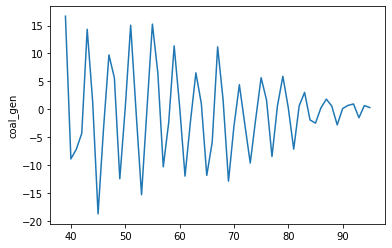

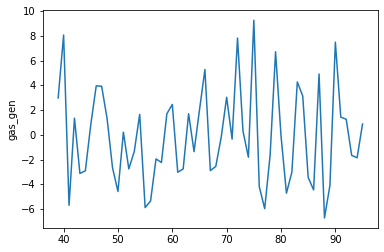

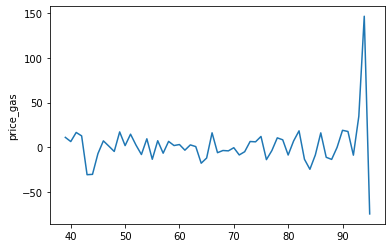

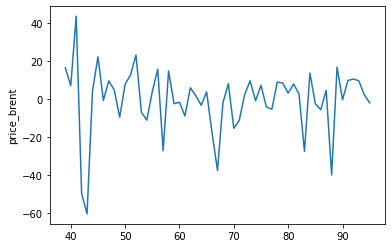

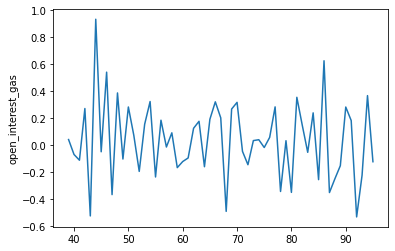

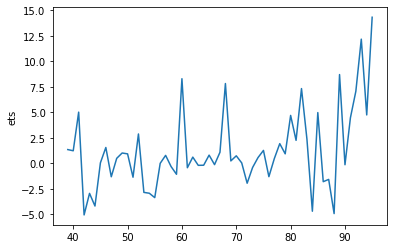

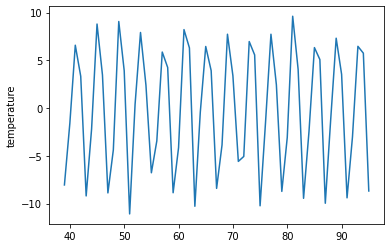

In [164]:
######### DATA CORRECTION #########
#ideally, for each set, apply specific changes
# detrending for linear processes
# differences for random walks 
# other ? non linear processes

#### differentiate 1
DataSeriesCorr=[]
for df in DataSeries:
    if df.name == "open_interest_gas":
        df_log = pd.Series(np.log(df))
        df = df_log
    df_diff = df.diff().dropna()
    plt.plot(df_diff)
    plt.ylabel(df.name)
    plt.show()
    DataSeriesCorr.append(df_diff)

DataSeries = DataSeriesCorr

df_corr = pd.concat(DataSeriesCorr,axis=1)

In [165]:
######### STATIONARITY DATA TEST #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary


dfdifull = normality_test_matrix(df_corr, variables = df_corr.columns, test="Dickey-Fuller")
dfdifull.style.apply(highlight_cells_DF, subset=['p-value Dickey-Fuller'], axis=0)


Results for Dickey-Fuller test


,test statistic Dickey-Fuller,p-value Dickey-Fuller,lags used Dickey-Fuller
coal_gen,-1.684991,0.438862,8.000000
gas_gen,-7.646230,0.000000,1.000000
price_gas,-2.271645,0.181276,6.000000
price_brent,-7.393199,0.000000,0.000000
open_interest_gas,-6.362847,0.000000,2.000000
ets,-1.675849,0.443597,4.000000
temperature,-4.925180,0.000031,10.000000


In [166]:
dfkpss = normality_test_matrix(df_corr, variables = df_corr.columns, test="KPSS")
dfkpss.style.apply(highlight_cells_KPSS, subset=['p-value KPSS'], axis=0)

Results for KPSS test


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range

,test statistic KPSS,p-value KPSS,lags used KPSS
coal_gen,0.137035,0.100000,12.000000
gas_gen,0.085583,0.100000,10.000000
price_gas,0.196421,0.100000,7.000000
price_brent,0.072597,0.100000,6.000000
open_interest_gas,0.250526,0.100000,5.000000
ets,0.598448,0.022777,3.000000
temperature,0.346539,0.100000,11.000000


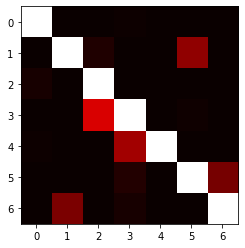

,coal_gen_x,gas_gen_x,price_gas_x,price_brent_x,open_interest_gas_x,ets_x,temperature_x
coal_gen_y,1.0000,0.0001,0.0010,0.0043,0.0001,0.0033,0.0001
gas_gen_y,0.0003,1.0000,0.0325,0.0025,0.0000,0.2012,0.0007
price_gas_y,0.0229,0.0002,1.0000,0.0008,0.0005,0.0000,0.0016
price_brent_y,0.0002,0.0016,0.3124,1.0000,0.0000,0.0093,0.0004
open_interest_gas_y,0.0077,0.0001,0.0004,0.2302,1.0000,0.0000,0.0000
ets_y,0.0000,0.0001,0.0005,0.0368,0.0025,1.0000,0.1609
temperature_y,0.0011,0.1697,0.0037,0.0203,0.0000,0.0033,1.0000


In [167]:
#### CORRECTED GRANGER CAUSALITY ####

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    plt.imshow(df, cmap='hot', interpolation='nearest')
    plt.show()
    return df


##### actual test
grangers_causation_matrix(df_corr, variables = df_corr.columns)        


In [168]:
def plot_gen(series):
    plt.figure(figsize=(12,6))
    plt.plot(series, color='red')
    plt.grid()
    plt.ylabel('Generation output (GWh)', fontsize=16)

def plot_price(series):
    plt.figure(figsize=(12,6))
    plt.plot(series, color='green')
    plt.grid()
    plt.ylabel('Price p/term', fontsize=16)

def plot_basic(series, name):
    plt.figure(figsize=(9,4))
    plt.plot(series)
    plt.ylabel(name, fontsize=10)
    plt.grid()


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


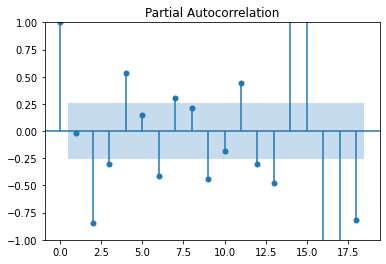

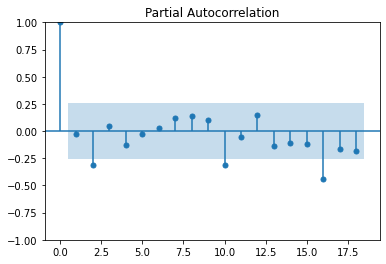

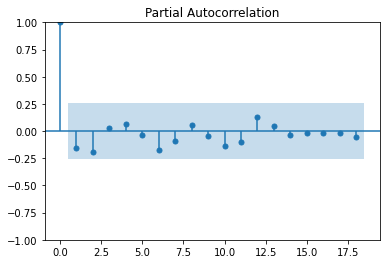

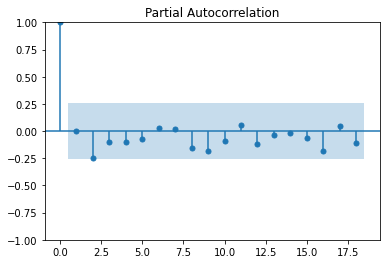

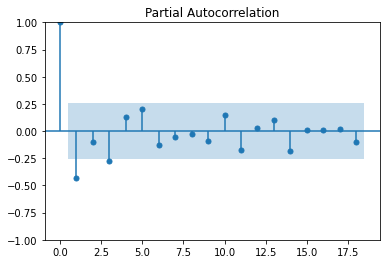

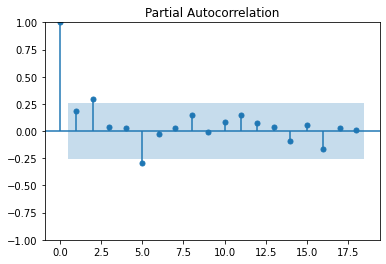

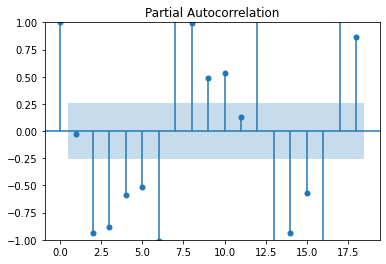

In [169]:
######### LAG LENGTH CRITERIA ######### either multiple of frequency or Schwarz, akaike, hannan-quinn, bayesian 

for df in DataSeries:
    plot_pacf(df)
    plt.show()



# for df in DataSeries:
#     lag_selection = _autolag(mod=VAR,endog=df, exog=df, startlag=1, maxlag=30, method="aic")
#     lag_selection.results()
#     #plt.show()




In [176]:
##### MODEL FITTING #####

model = VAR(df_corr)
x = model.select_order(maxlags=6)
x.summary()
#model_fit = model.fit(maxlags=10, ic="aic") #aic, or bic
#model_fit.summary()


#model_fit.plot()


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,20.17,20.44*,5.751e+08,20.27
1,19.41,21.53,2.730e+08,20.22
2,17.22,21.20,3.413e+07,18.74
3,15.93,21.77,1.270e+07,18.16
4,14.93,22.62,8.908e+06,17.86
5,14.01,23.56,1.370e+07,17.66
6,9.390*,20.79,2.766e+06*,13.75*


In [178]:
##### MODEL FITTING BASED ON LAG CRITERIA RESULTS ######

lag_order = 6
model_fit = model.fit(lag_order)
model_fit.summary()

#model_fit.plot()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 20, Jun, 2022
Time:                     14:52:50
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    20.7914
Nobs:                     51.0000    HQIC:                   13.7468
Log likelihood:          -445.003    FPE:                2.76605e+06
AIC:                      9.38988    Det(Omega_mle):         38278.7
--------------------------------------------------------------------
Results for equation coal_gen
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.744147         2.116887            0.352           0.725
L1.coal_gen                 -0.228150         0.466039           -0.490           0.624
L1.gas_gen                  -

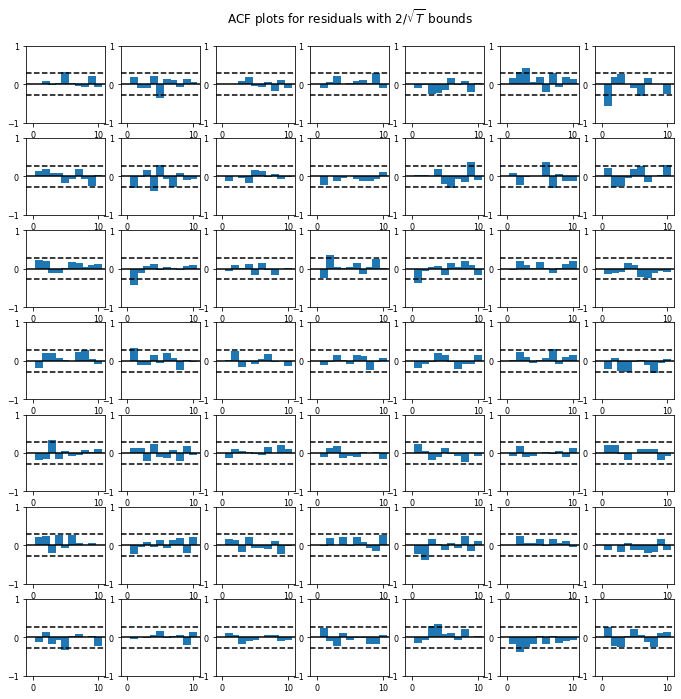

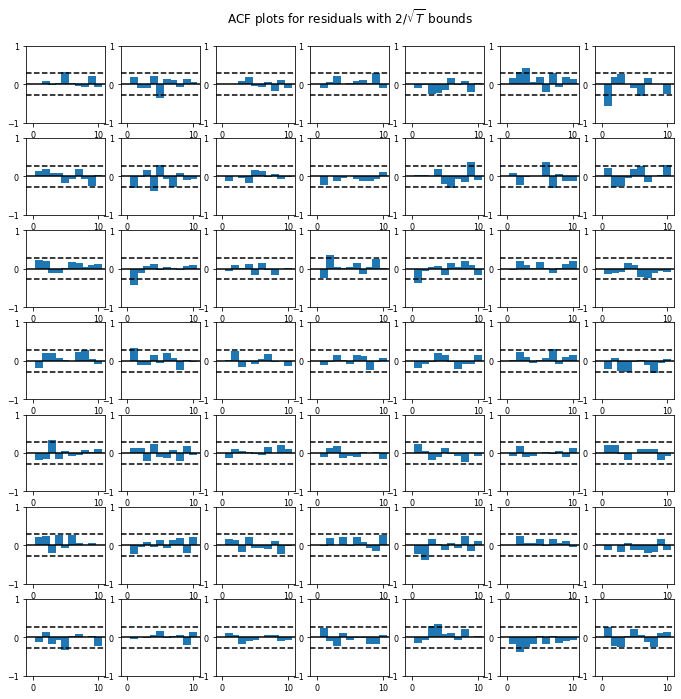

In [179]:
######### STABILITY RESIDUALS AUTOCORRELATION #########
model_fit.plot_acorr()

#if residuals out of range -> unstable model 

In [180]:
######### GRANGER CAUSALITY TEST #########
#for gas price
GrangerCausality = model_fit.test_causality('gas_gen', ['temperature'], kind='f')
print(GrangerCausality.summary())

#granger causality test : HO not rejected => there is some causality between the variables
#this test is done based on the model ie, it tests the models coefficients and not directly the variables
#importance of the order: if p value higher, does it mean that one variable is generating the other ?

Granger causality F-test. H_0: temperature does not Granger-cause gas_gen. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
         3.658          2.266   0.004 (6, 56)
---------------------------------------------


FEVD for coal_gen
      coal_gen   gas_gen  price_gas  price_brent  open_interest_gas       ets  temperature
0     1.000000  0.000000   0.000000     0.000000           0.000000  0.000000     0.000000
1     0.489889  0.018297   0.228836     0.001133           0.240154  0.019634     0.002055
2     0.189946  0.005132   0.664469     0.016735           0.093264  0.020531     0.009924
3     0.181653  0.004586   0.612423     0.063125           0.098907  0.030070     0.009238
4     0.159498  0.037613   0.545129     0.057847           0.159923  0.026216     0.013774
5     0.160164  0.043994   0.529718     0.054537           0.167549  0.029509     0.014529
6     0.131199  0.051386   0.559868     0.084948           0.135201  0.024255     0.013144
7     0.140585  0.047690   0.539377     0.081162           0.145866  0.033811     0.011508
8     0.154328  0.046875   0.503696     0.093223           0.153171  0.037931     0.010775
9     0.151296  0.057854   0.493775     0.100417           0.145428  0.0

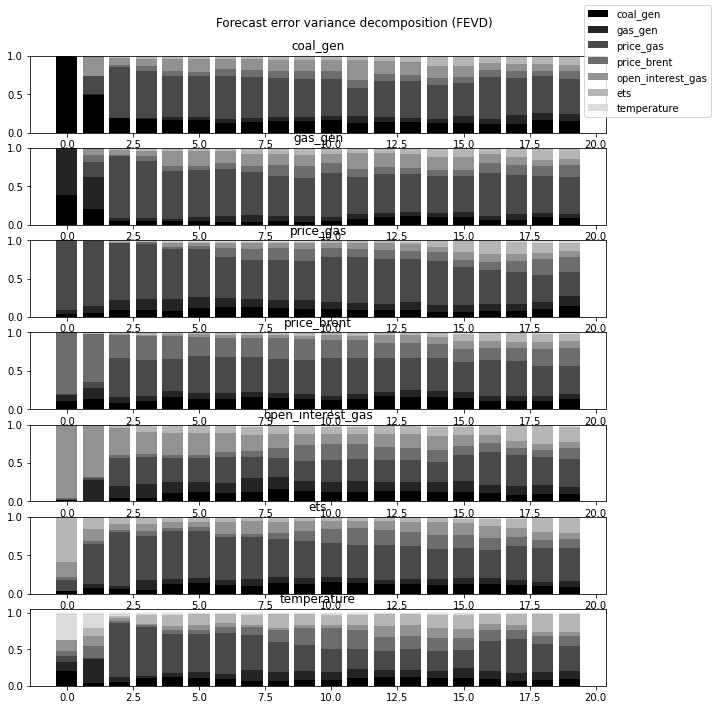

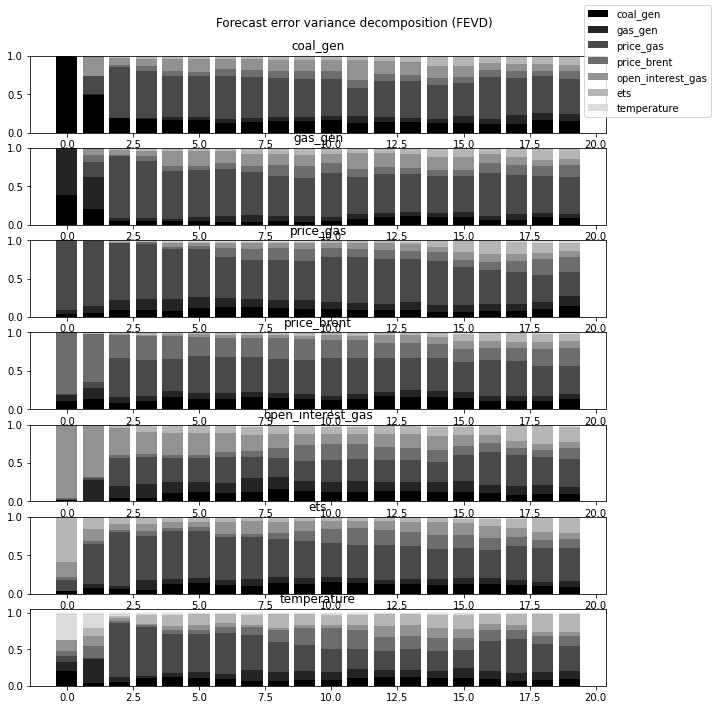

In [182]:
######### FORECAST VARIANCE ERROR DECOMPOSITION: #########

#only for 20 periods
n=20
fevd = model_fit.fevd(n)
fevd.summary()


#affichage pour n périodes
model_fit.fevd(n).plot()

IMPULSE RESPONSE ANALYSIS:

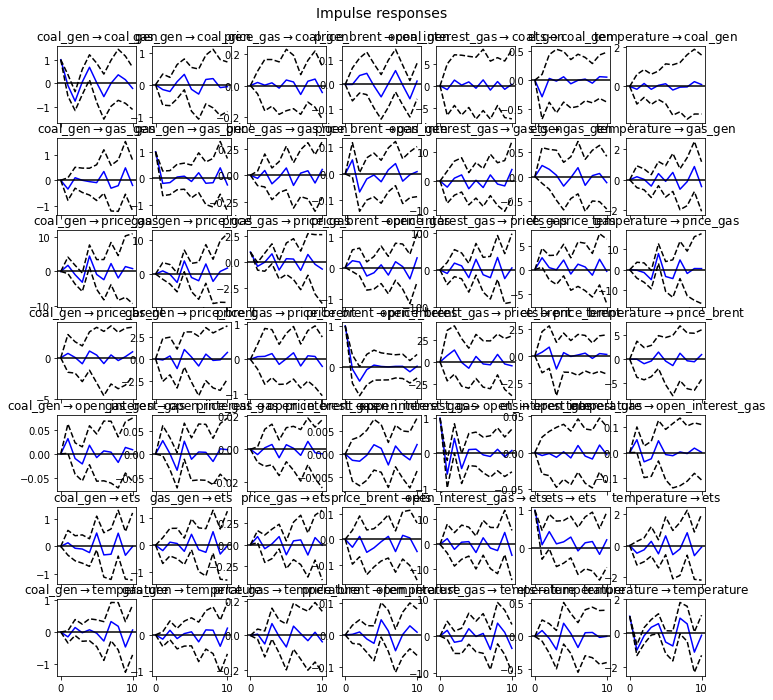

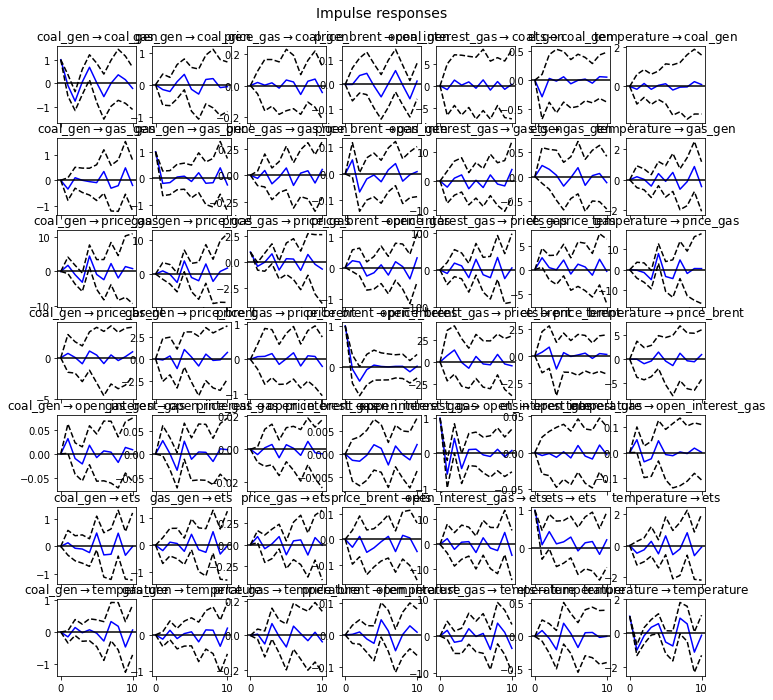

In [156]:
irf = model_fit.irf(10)
irf.plot()

OTHER MODELS

In [157]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_corr['price_gas'], order=(0, 3, 3)) 
results_ARIMA = model.fit()

results_ARIMA.summary()
#results_ARIMA.forecast(3)[0]


#results_ARIMA.plot_predict(start=20)
#plt.show()

/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              price_gas   No. Observations:                   57
Model:                 ARIMA(0, 3, 3)   Log Likelihood                -263.540
Date:                Mon, 20 Jun 2022   AIC                            535.080
Time:                        14:51:37   BIC                            543.035
Sample:                             0   HQIC                           538.148
                                 - 57                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.9689     59.891     -0.050      0.960    -120.352     114.415
ma.L2          2.9677    121.933      0.024      0.981    -236.017     241.952
ma.L3         -0.9988     61.137     -0.016      0.987    -120.824     118.827
sigma2       687.4923   4.21e+04      0.016      0.987   -8.19e+04    8.33e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):               487.24
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               7.95   Skew:                             1.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""